### Tests

In [5]:
import sys, os
sys.path.append('../../src')

import astropy.coordinates as coord

from astropy.io.votable import parse
from astropy.table import Table
from astropy import units as u

import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from math import ceil
import gaia_utils as gu
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)

clustername = "NGC 2682"
RADIUS   = 1.0
kCluster = 6
votable_disk = False
BINSIZE = 64
SIGMA = 1.0
distclust = 830.0
XYRANGE = [-20., 20]
WEIGHT = [20.,5.,5.,6.,6.]

In [6]:
from astroquery.gaia import Gaia

# tables = Gaia.load_tables(only_names=True)

#for table in (tables):
#    print (table.get_qualified_name())
    

In [7]:
# c = coord.SkyCoord.from_name("M47")
#c = coord.SkyCoord.from_name("NGC 2682")

print("## Query to GAIA...")
c = coord.SkyCoord.from_name(clustername)
c_icrs = coord.SkyCoord(ra= (c.ra.deg+RADIUS/10)* u.degree, dec= (c.dec.deg+RADIUS/10)*u.degree, frame='icrs')

pos = c_icrs.galactic
clusterPos = [pos.l.value, pos.b.value]
print(clusterPos)

queryaql = "SELECT * FROM gaiadr2.gaia_source WHERE \
CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS' \
,%f ,%f,%f))=1;"%(c.ra.deg+RADIUS/10.,c.dec.deg+RADIUS/10.,RADIUS)


job = Gaia.launch_job_async( queryaql, dump_to_file=True)
# print (job)

print("## Query done...")
data = job.get_results()

#voname = "n2516.vot"
#voname = "n2682.vot"
#votable = parse(voname)

#for table in votable.iter_tables():
#    data = table.array
#    print(data.dtype.names)

print("## data loaded....")

## Query to GAIA...
[215.637191012369, 32.02698511262987]
## Query done...
## data loaded....


In [8]:
## Filter the data
##

def plot_check(a1, a2, ifinal):
    "check the filltering"
    
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)

# ax.scatter(cluster_candidates["ra"], cluster_candidates["dec"], s=1, c="#000000")
    print(len(a1))
    print(len(a2))
    
    axarr[0,0].scatter(a1, a2, s=1, c="#000000")
    axarr[0,0].set_xlabel("a1")
    axarr[0,0].set_ylabel("a2")
    axarr[0,0].set_ylim([0,2000])

    axarr[0,1].scatter(a1[ifinal], a2[ifinal], s=1, c="#000000")
    axarr[0,1].set_xlabel("a1[ifinal]")
    axarr[0,1].set_ylabel("a2[ifinal]")

    plt.show()

def filter_data(lgal, bgal, distance, vra, vdec, cartesian = False, dist_range = [0., 2000], vra_range = [-200,200], vdec_range = [-200.,200]):
    "filter the data applying the range and return the sklearn-centric array"
    
    i1 = np.where((distance >= dist_range[0]) & (distance < dist_range[1]))
    i2 = np.where((vra >= vra_range[0]) & (vra < vra_range[1]))
    i12 = np.intersect1d(i1,i2)
    i3 = np.where((vdec >= vdec_range[0]) & (vdec < vdec_range[1]))
    ifinal = np.intersect1d(i12,i3)
    
    datask = np.zeros((len(ifinal),5))
    
    if cartesian:
        xx, yy, zz = convert_to_cartesian(lgal[ifinal], bgal[ifinal], distance[ifinal], offCenter = clusterPos)
        datask[:,0] = xx
        datask[:,1] = yy
        datask[:,2] = zz
        datask[:,3] = vra[ifinal]
        datask[:,4] = vdec[ifinal]
    else:
        datask[:,0] = lgal[ifinal]
        datask[:,1] = bgal[ifinal]
        datask[:,2] = distance[ifinal]
        datask[:,3] = vra[ifinal]
        datask[:,4] = vdec[ifinal]
    
    return(datask)
    
    

In [9]:
#Normalized the 5d datask with linear projection from [min,max] to [0,1]
def normalization0_1(data):
    result = np.zeros(data.shape)
    normalization_vector = np.zeros((6,2)) #Represente max and min    
    
    for i in range(5) :
        normalization_vector[i,0] = np.max(data[:,i]) # max
        normalization_vector[i,1] = np.min(data[:,i]) # min
        result[:,i] =   (data[:,i]-normalization_vector[i,1])/( WEIGHT[i] * (normalization_vector[i,0]-normalization_vector[i,1]))  
        
    return(result,normalization_vector)

#Unnormalized Data with linear projection from [0,1] to [min,max]
def unnormalization0_1(data,normalization_vector):
    result = np.zeros(data.shape) 
    for i in range(5) :
        result[:,i] =  (WEIGHT[i] *  data[:,i])*(normalization_vector[i,0]-normalization_vector[i,1]) + normalization_vector[i,1]
        
    return(result)
                        

In [10]:
## plot2D and plot3D


def plot2d_labels(a1,a2,labels,nclusterk,centroid,xylab = ["a1","b1"], distlab = 0, title = "Title", clustername= "NGC"):
    figname = "%s-2Dkmeans-gaia.png"%(clustername)
    rcParams['figure.figsize'] = 14, 21
    nrow = int(ceil(nclust / 3))
    ncol = 3           
    f, axarr = plt.subplots(nrow, ncol)

    for i in range(nclusterk):
        ilabel = np.where(labels == i)[0]
        row = int(ceil(i / 3)) - 1
        col = i % 3
        axarr[row,col].scatter(a1[ilabel],a2[ilabel], s=1, c="#000000")
        axarr[row,col].set_xlabel(xylab[0])
        axarr[row,col].set_ylabel(xylab[1])
        
        txt = "Stars:%d Dist:%3.1f Vra:%3.1f Vdec:%3.1f"%(len(ilabel), centroid[i][distlab],centroid[i][3],centroid[i][4])
        axarr[row,col].text(-0.1,1.02, txt, size=12, ha="left", 
         transform=axarr[row,col].transAxes)
        
    plt.savefig(figname)
    plt.show()

def plot2d_filtered_labels(a1,a2,labels,nclusterk,centroid, xylab = ["a1","b1"], distlab = 0, title = "Title", clustername= "NGC" , xyrange = []):
    
    "filtering with wavelet."
    
    gaia = gu.gaiaSet()
    
    figname = "%s-2Dkmeans-filtered-gaia.png"%(clustername)
    rcParams['figure.figsize'] = 14, 21
    nrow = int(ceil(nclust / 3))
    ncol = 3           
    f, axarr = plt.subplots(nrow, ncol)

    for i in range(nclusterk):
        ilabel = np.where(labels == i)[0]
        row = int(ceil(i / 3)) - 1
        col = i % 3
        im , imf = gaia.sampling_filtering(a1[ilabel],a2[ilabel], BINSIZE, SIGMA, xrange = xyrange, yrange = xyrange)
        
        axarr[row,col].imshow(imf, cmap = 'gist_stern')
        axarr[row,col].set_xlabel(xylab[0])
        axarr[row,col].set_ylabel(xylab[1])
        
        txt = "Stars:%d Dist:%3.1f Vra:%3.1f Vdec:%3.1f"%(len(ilabel), centroid[i][distlab],centroid[i][3],centroid[i][4])
        axarr[row,col].text(-0.1,1.02, txt, size=12, ha="left", 
         transform=axarr[row,col].transAxes)
        
    plt.savefig(figname)
    plt.show()
  

def plot3d_labels(a1,a2,a3,labels,nclusterk,centroid,xylab = ["X","Y","Z"], title = "Title", clustername= "NGC"):
    figname = "%s-3Dkmeans-gaia.png"%(clustername)
    rcParams['figure.figsize'] = 14, 21
    nrow = int(ceil(nclust / 3))
    ncol = 3
    
    fig = plt.figure()

    for i in range(nclusterk):
        ilabel = np.where(labels == i)[0]
        row = int(ceil(i / 3)) 
        col = i % 3 + 1
        axarr = fig.add_subplot(nrow,ncol,i+1, projection='3d')
        axarr.scatter(a1[ilabel],a2[ilabel],a3[ilabel], c="r",marker ="*")
        axarr.set_xlabel(xylab[0])
        axarr.set_ylabel(xylab[1])
        axarr.set_zlabel(xylab[2])
    
    plt.savefig(figname)
    plt.show()

In [11]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

radial_velocity
    km.s**-1   
---------------
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
            ...
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
         -999.0
Length = 19299 rows
153.589617210828
## Total stars: 19299
[1.8948e+04 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.3000e+01 2.5100e+02
 6.8000e+01 9.0000e+00]
[-999.         -941.37051914 -883.74103828 -826.11155742 -768.48207656
 -710.8525957  -653.22311484 -595.59363398 -537.96415312 -480.33467226
 -422.70519139 -365.07571053 -307.44622967 -249.81674881 -192.18726795
 -134.55778709  -76.92830623  -19.29882537   38.33065549   95.96013635
  153.58961721]
215.637191012369
32.026985112629

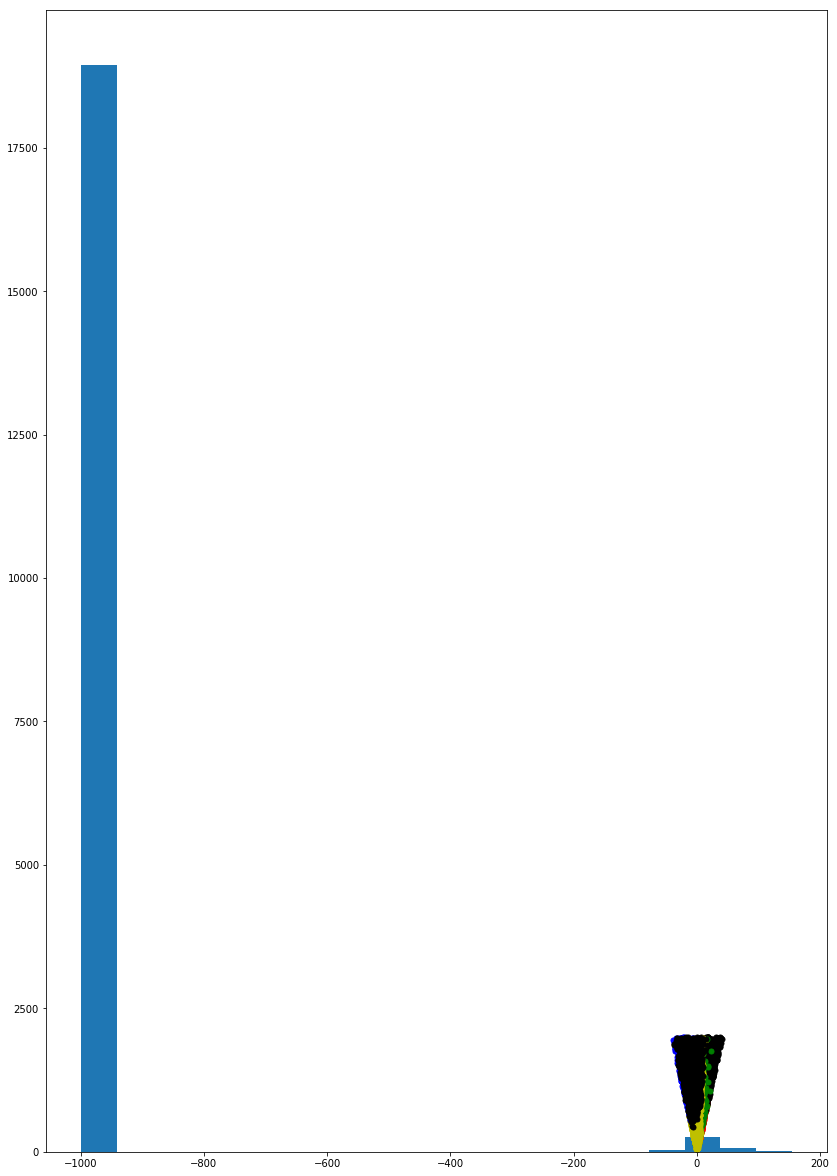

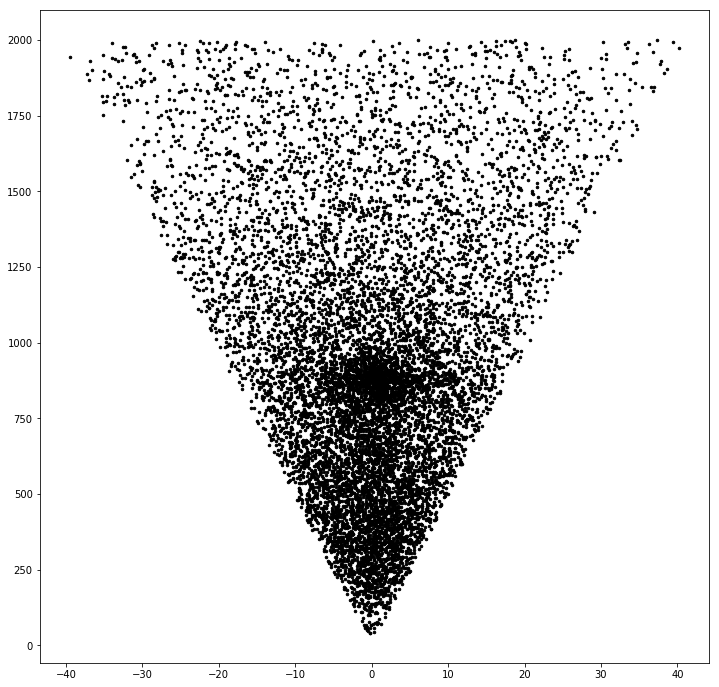

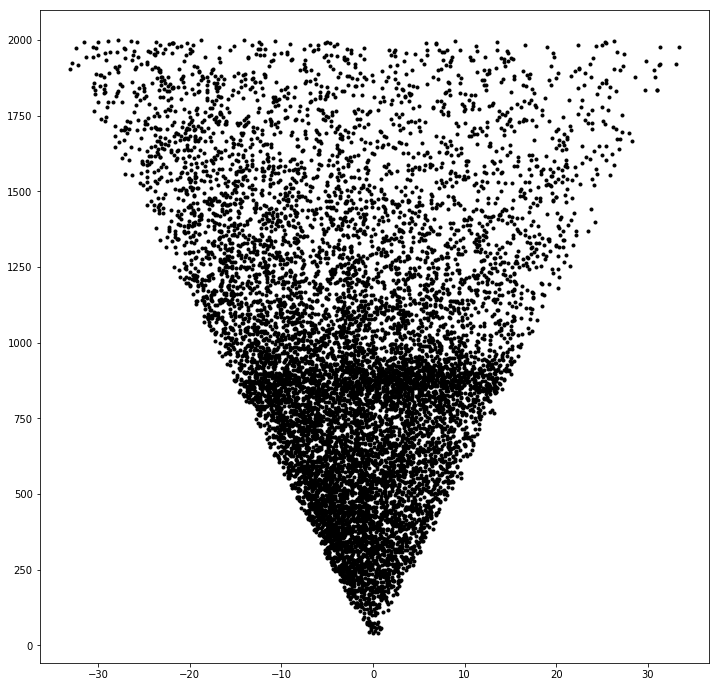

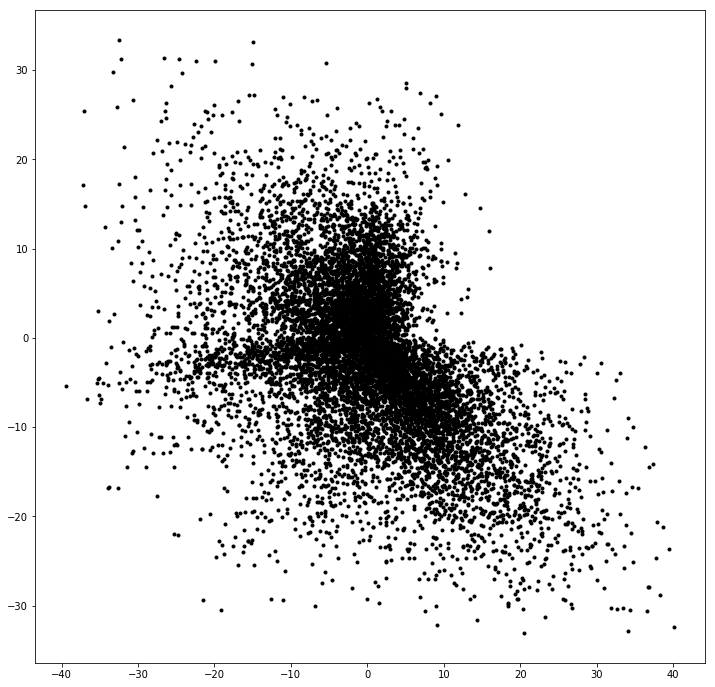

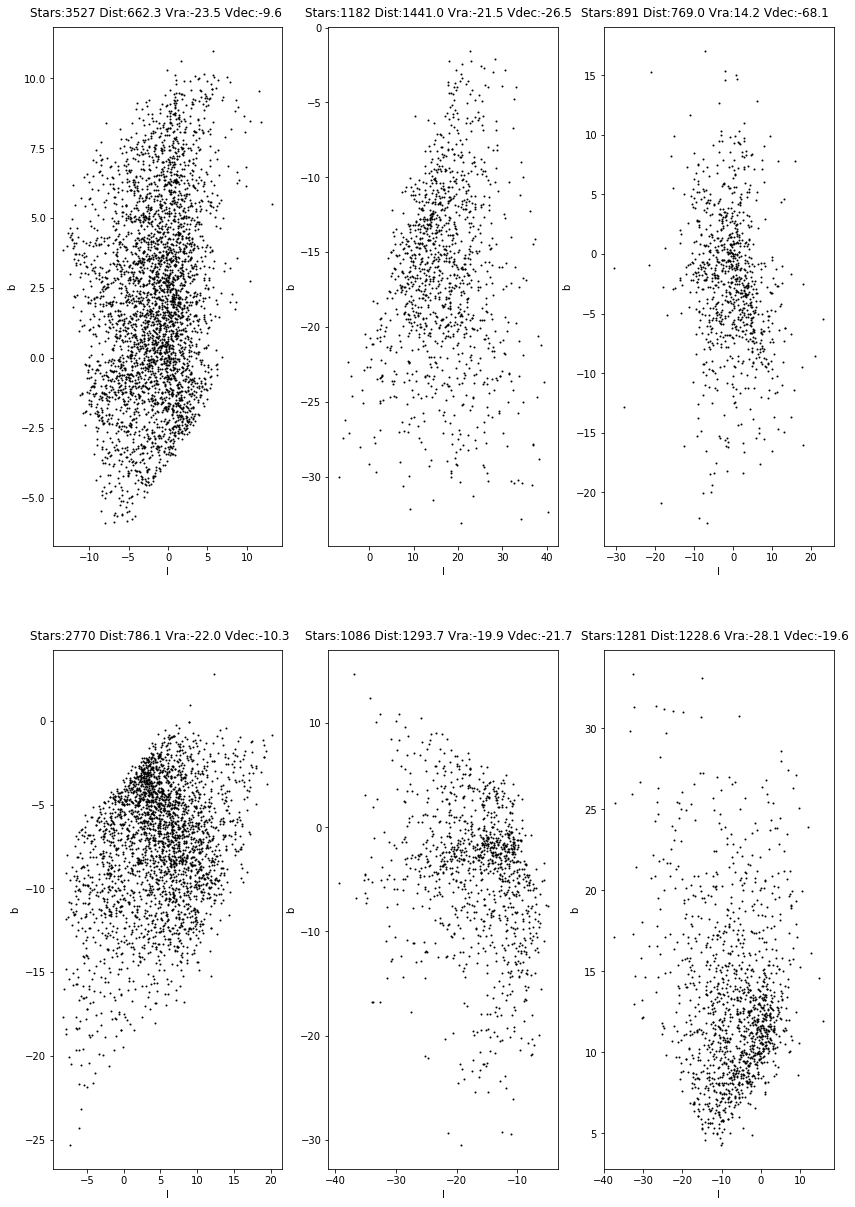

3060
## std: 0.499191
5904
## std: 0.456447
6996
## std: 0.454169
2856
## std: 0.499668
5532
## std: 0.463017
6360
## std: 0.485199


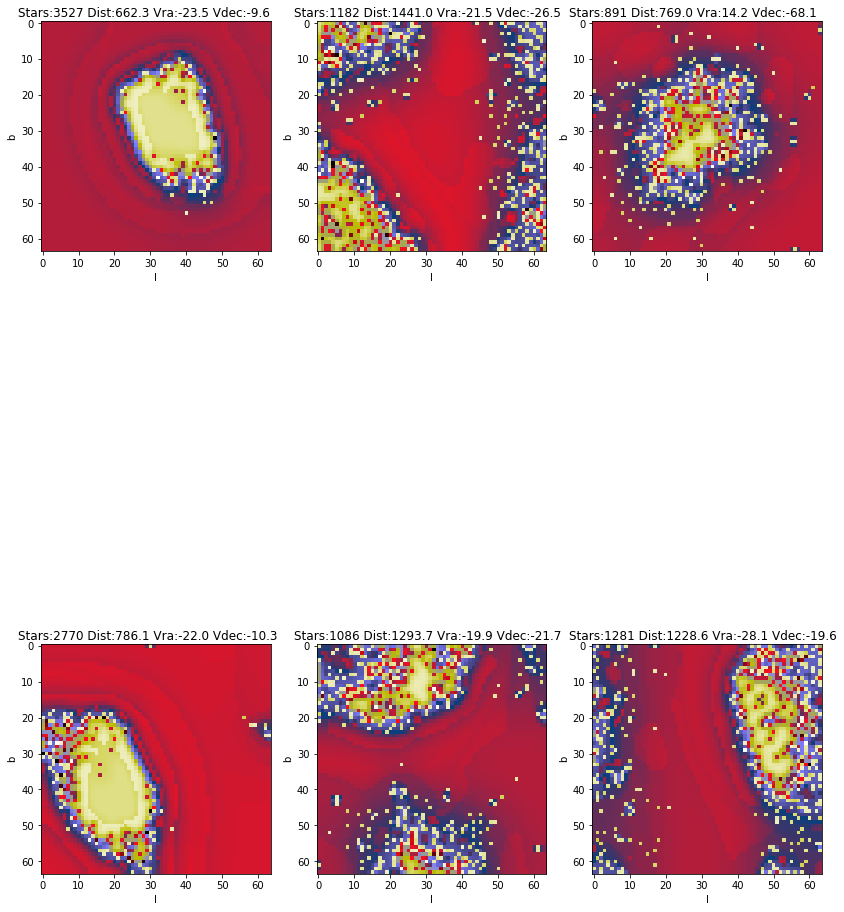

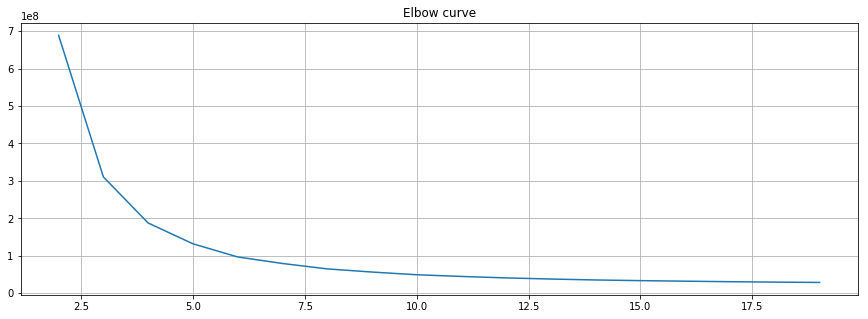

In [15]:
## Reading the votable

#voname = "m47_off.vot"
#voname = "ngc2232.vot"
# voname = "ngc2682_2deg.vot"
    
lgal = data['l']
bgal = data['b']
pmas = data['parallax']
distance = 1000. / np.ma.filled(pmas, -9999.)
pmra = np.ma.filled(data['pmra'], -999999999.)
pmdec= np.ma.filled(data['pmdec'],-9999999.)
vdec = 4.74 *  pmdec / pmas   ##?
vra  = 4.74 *  pmra  / pmas
vradial = np.ma.filled(data['radial_velocity'], -999.0)
print(vradial)
print(max(vradial))
print("## Total stars: %d"%(len(lgal)))

h , bins, patch =  plt.hist(vradial , 20)
print(h)
print(bins)

## mashing the data ...
##


# datask = np.zeros((len(vra),5))
datask = filter_data(lgal,bgal,distance,vra,vdec , cartesian = True)
datanor2, normalization_vector2 = normalization0_1(datask)


print("## Stars selected: %d"%(len(datask[:,0])))

## fitted cluster in k-means
nclust = kCluster

print("## computing k-means...")
kmeans = KMeans(n_clusters=nclust, max_iter = 500, n_init = 50)
kmeans.fit(datanor2)

centroid = unnormalization0_1(kmeans.cluster_centers_,normalization_vector2)

# centroid = kmeans.cluster_centers_
labels = kmeans.labels_

print("## Centroids:")
print(centroid)

#print(labels)
for i in range(nclust):
    nstar = len(np.where(labels == i)[0])
    print("## Label: %d, %d stars"%(i,nstar))


colors = ["r.","k.","g.","y.","b.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c."]
rcParams['figure.figsize'] = 12, 12

for i in range(nclust):
    ilabel = np.where(labels == i)[0]
    plt.plot(datask[ilabel,1],datask[ilabel,0],colors[i],markersize=10)
    
plt.show()

plt.plot(datask[:,1],datask[:,0], "k.", markersize = 5)
plt.show()
plt.plot(datask[:,2],datask[:,0], "k.")
plt.show()
plt.plot(datask[:,1],datask[:,2], "k.")
plt.show()


## plot the different clusters

a1 = datask[:,1]     ## l
a2 = datask[:,2]     ## b

plot2d_labels(a1,a2,labels,nclust,centroid,xylab = ["l","b"], distlab = 0, title = "Title", clustername= "%s-%3.0fpc"%(clustername, distclust))
plot2d_filtered_labels(a1,a2,labels,nclust,centroid,xylab = ["l","b"],distlab = 0, title = "Title", clustername= "%s-%3.0fpc"%(clustername, distclust), xyrange = XYRANGE)


### Elbow method
X = datask
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

    

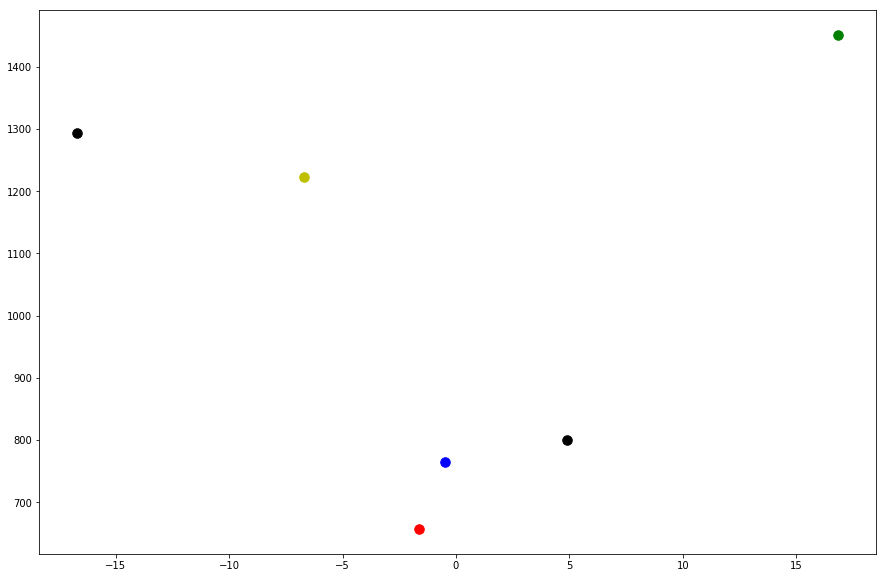

In [13]:
# Plotting i2 with respect to i1
# (0 = lgal; 1 = bgal; 2 = distance...)
i1 = 1
i2 = 0

plt.figure(figsize=(15,10))
for i in range(nclust):
    #plt.subplot(4,3,i+1)
    ilabel = np.where(labels == i)[0]
    #plt.plot(datask[ilabel,i1],datask[ilabel,i2],colors[i],markersize=1)
    plt.plot(centroid[i,i1],centroid[i,i2],colors[i],markersize=19)
    #plt.xlabel(data_name[i1], fontsize=22)
    #plt.ylabel(data_name[i2], fontsize=22)
    #plt.title("num. " + str(i) + " " + data_name[i2] + "=" + str(round(centroid[i,i2],2)), fontsize=22)
    
plt.show()